In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Ussin, Erik (1034012)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

3 dense layers are used of 75%, 70% and 65% of nodes compared to its previous layer. This provided the best balance between training time and validation accuracy. The output layer uses Softmax since we have 10 output classes. Adagrad was used as optimizer for its learning rate decay to improve accuracy. The model achieves 78% validation accuracy in 8 epoch and 85% in 30. The latter however is highly overfitted.  (length: 416)



Max val score: 78.62%


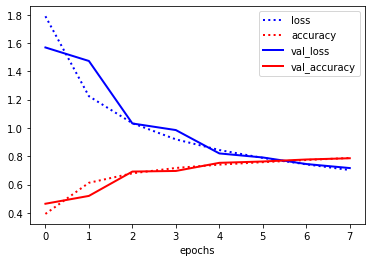

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 2304)              7080192   
_________________________________________________________________
dense_69 (Dense)             (None, 1612)              3715660   
_________________________________________________________________
dense_70 (Dense)             (None, 1048)              1690424   
_________________________________________________________________
dense_71 (Dense)             (None, 10)                10490     
Total params: 12,496,766
Trainable params: 12,496,766
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_1():
    model = models.Sequential()
    nodes = 32 * 32 * 3
    model.add(layers.Re

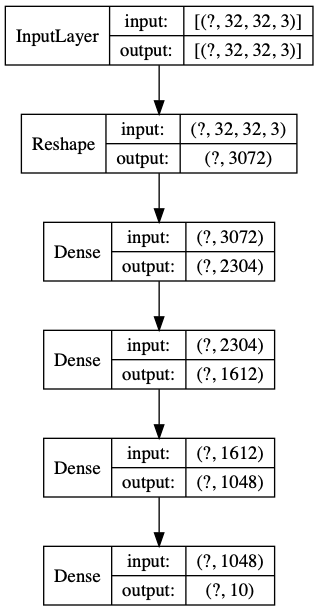

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

The network structure is the same as 1_1. All values are transformed to the range -1, 1, this zero centers the data which is potentially beneficial to L1/L2 regularizers. This model has 1/12 the number of trainable parameters of 1_1 which makes it much faster to train. The drawback is that it overfits quicker as within 8 epoch the validation accuracy is 82% whilst the test accuracy is 85%. Overall it outperforms 1_1.  (length: 422)



Max val score: 82.46%


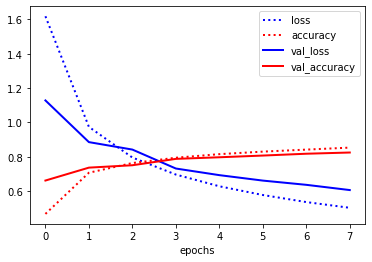

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_80 (Dense)             (None, 768)               787200    
_________________________________________________________________
dense_81 (Dense)             (None, 537)               412953    
_________________________________________________________________
dense_82 (Dense)             (None, 349)               187762    
_________________________________________________________________
dense_83 (Dense)             (None, 10)                3500      
Total params: 1,391,415
Trainable params: 1,391,415
Non-trainable params: 0
_________________________________________________________________
None
def build_model_1_2():
    model = models.Sequential()
    nodes = 32 * 32 * 1
    model.add(layers.Resh

In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

L2 and L1 regularization resolved the overfitting problem as the model is much less overfitted than 1_2 with the downside that it required 24 epochs instead of 8 to reach the slightly higher accuracy of 83.2%. The learning rate was also slightly decreased to increase the accuracy and the batch size was doubled to attempt to counter-balance the time required by the increased number of epochs.  (length: 396)



Max val score: 83.17%


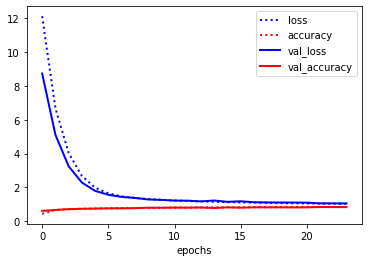

def build_model_1_3():
    model = models.Sequential()
    nodes = 32 * 32 * 1
    model.add(layers.Reshape((nodes,), input_shape=(32,32,1)))
    nodes = nodes * (0.75)
    model.add(layers.Dense(
        nodes, 
        kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.005), 
        bias_regularizer=regularizers.l2(0.01),
        activation='relu'
    ))
    nodes = nodes * (0.70)
    model.add(layers.Dense(
        nodes, 
        kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.005), 
        bias_regularizer=regularizers.l2(0.01),
        activation='relu'
    ))
    nodes = nodes * (0.65)
    model.add(layers.Dense(
        nodes, 
        kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.005), 
        bias_regularizer=regularizers.l2(0.01),
        activation='relu'
    ))
    nodes = 10
    model.add(layers.Dense(nodes, activation='softmax'))
    
    model.compile(optimizer=optimizers.Adagrad(lr=0.01),
                  loss='categorical_crossentropy',
          

In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

The same pre-procesing from the previous model was used as this allowed a significant reduction on the number of parameters in the network, no additional steps were required. The model contains 4 convolutional layers. The 1st 2 convolutional layers are followed by a MaxPooling layer in order to reduce overfitting coupled with L2 regulizer on each convolutional layer as well as dropout layers in strategic places. Dropout layers noticeably reduced overfitting by ~3%. The model is slightly overfitted as it achieves 94.8% on the  validation data which is ~2% lower than on the training data. This could likely be resolved by data augmentation.  (length: 647)



Max val score: 94.82%


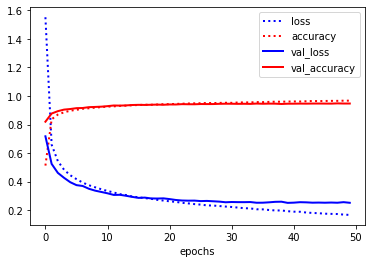

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 29, 29, 32)        544       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 26, 26, 32)        16416     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 10, 10, 64)        32832     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 7, 7, 64)          65600     
_________________________________________________________________
flatten_15 (Flatten)         (None, 3136)            

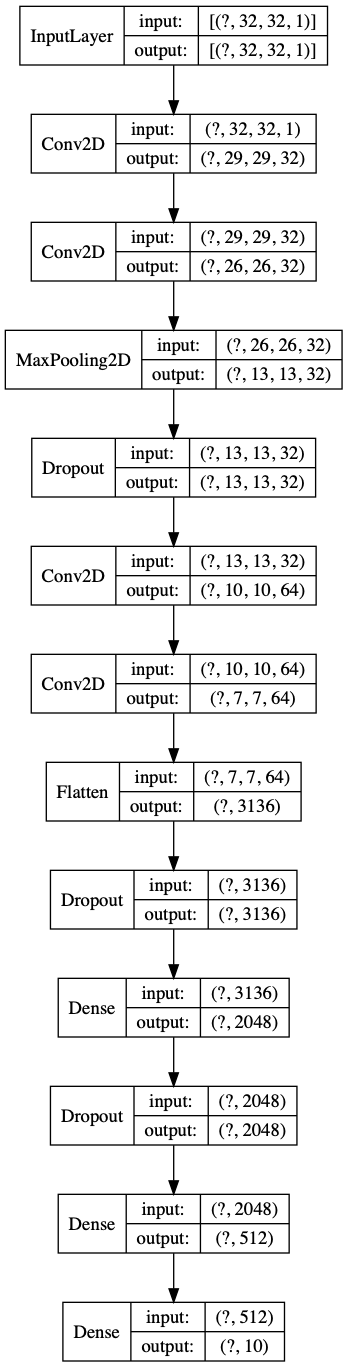

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

Rotation, shift and flipping did not appear to yeld better results. This makes sense because we are trying to identify the number at the center of the image. Zooming and shearing however improved the results in terms of overfitting. This yelded a result of 94.8% validation accuracy with roughly the same train data accuracy. Overall the model performs the same as 2_1 without overfitting.  (length: 391)



Max val score: 94.78%


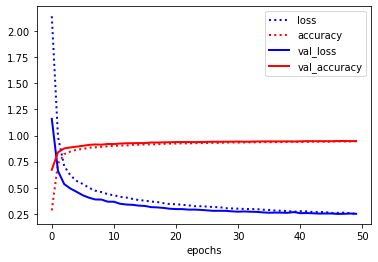


generator = ImageDataGenerator(
      rotation_range=0,
      width_shift_range=0.0,
      height_shift_range=0.0,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest') 


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

The model has an accuracy of 92.2%. The label that achieves the highest accuracy is 2 with 97.2% whilst the worst is 6 with 91.04%. By looking at the miss-classifications of label 6 it appears that the mistakes are done by a mix of blurryness in the images as well as the numbers being too big to be fully in the center of the image or other numbers are present in the image as well.  (length: 385)

Test score: 0.95%


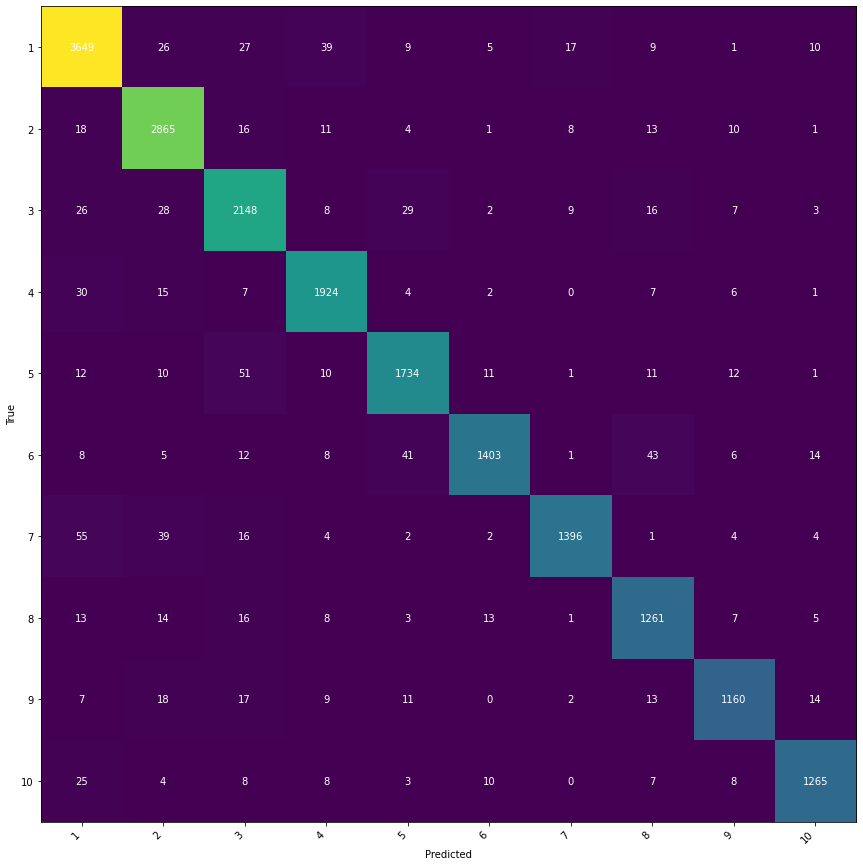

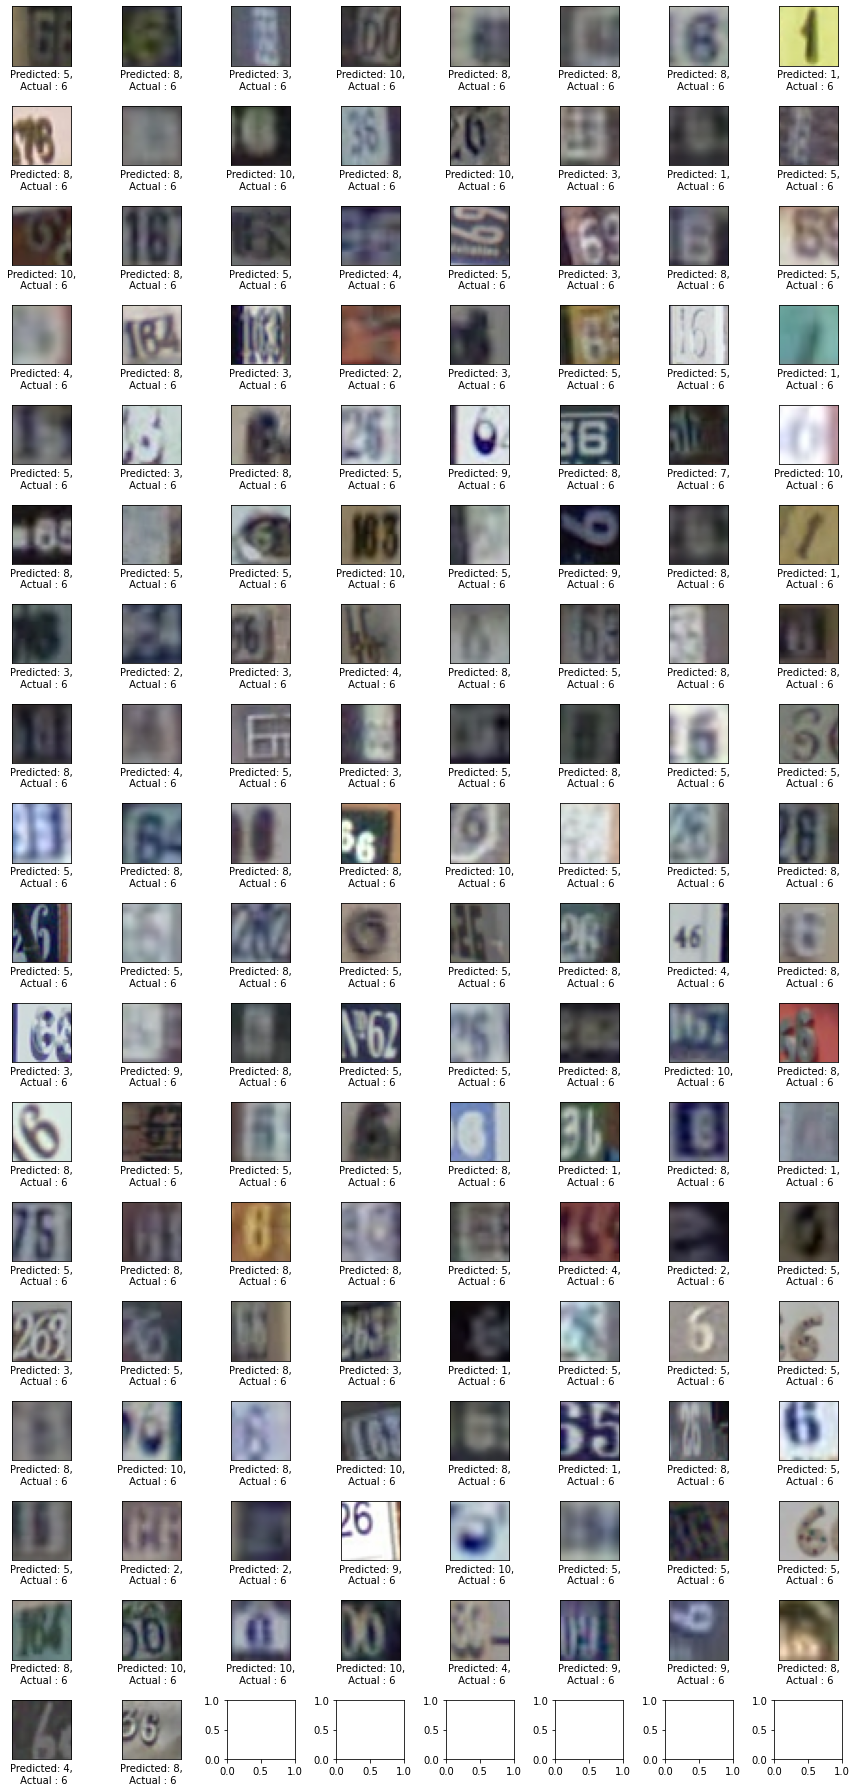

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

The 1st convolutional layer isolates the numbers in the image from the background and hence can be considered an edge detector. The 2nd seems to to look for lines whilst the 3rd looks for specific shapers and the 4rth is not very clear but it seems to be patters. The 3rd and 4rth layers are hard to tell what they are looking for as they are after a MaxPooling layer meaning the resolution is reduced.  (length: 404)



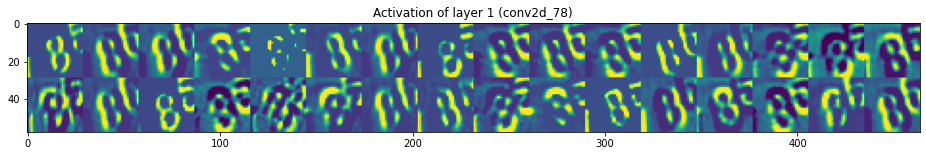

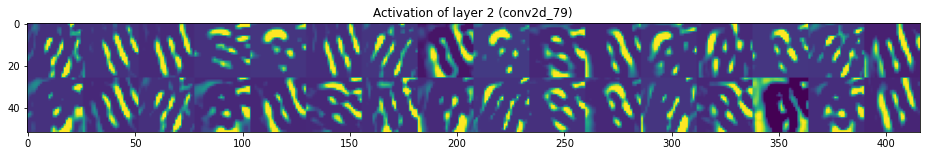

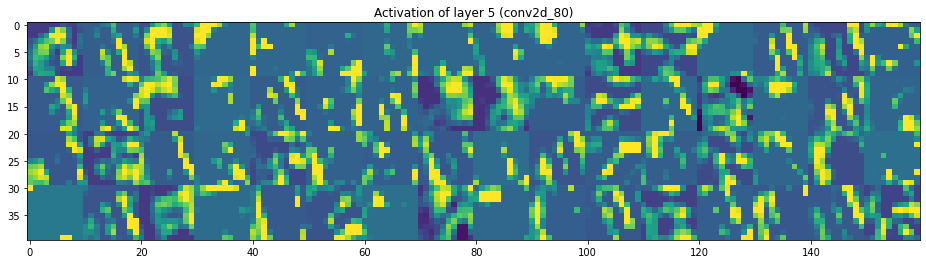

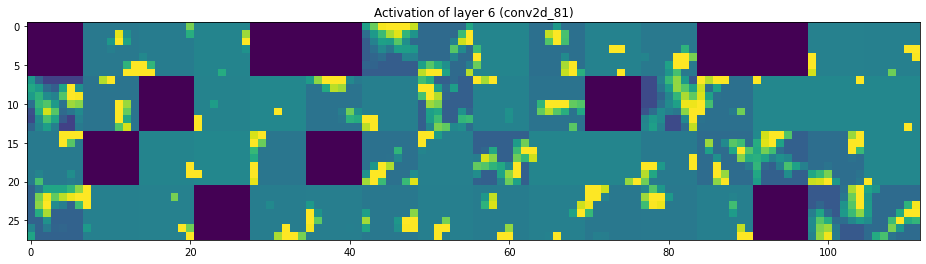

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

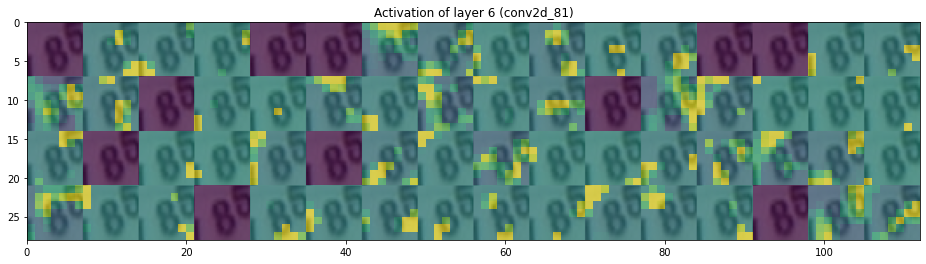

def plot_activation_map(model, img):
    activations = model.predict(rgb2gray([img]))
    plot_layer_activation(5, activations, True, img)



In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

Unfreezing the last block convolutional layers of the imagenet network substantially improves the validation accuracy of the network as it achieved ~81.5% instead of ~55% with it frozen. It is interesting to note however, that the network starts to overfit very quickly as within 5 epoch the accuracy is already ~3% higher than the validation accuracy. Adagrad was used given it provided good results in previous models.  (length: 422)



Max val score: 81.47%


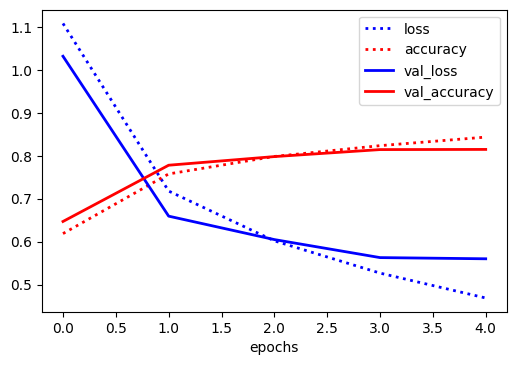

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
dense_41 (Dense)             (None, 10)                20490     
Total params: 15,785,802
Trainable params: 8,150,538
Non-trainable params: 7,635,264
_________________________________________________________________
None


def build_model_4_1():
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    # Select which layers to train and which not to train
    for layer in vgg16_base.layers:
        if layer.name == 'block5_conv1' or layer.name == 'block5_conv2' or layer.name == 'block5_conv3':
            layer.trainable = True
        else:
            layer.trainable = False
    # Extend vgg16_base model
    model = models.Sequential()
    model.add(vgg16_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    # Compile model
    model.compile(optimizer=optimizers.Adagrad(lr=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    # Return model
    return model



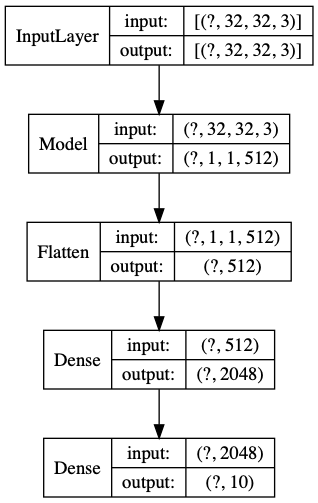

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

SVC and RandomForest were tested both of which input data ran through a StandardScaler. RandomForest outperformed SVC by ~1%. To reduce training time a split of the train data was used for training and a grid search on the relevant parameters of RandomForest and SVC was used to maximize the accuracy. These results are 83% validation accuracy which beat 4.1 but not the best model found thus far which achieves ~94.8%.  (length: 421)

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('scaler', StandardScaler())])),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=1))])
def store_embeddings():
   # Stores all necessary embeddings to file
    model_4_1 = load_model_from_file(base_dir, "model_4_1", extension='.h5')
    # Model with VGG only and last convolutional layer as output
    model = models.Model(inputs=model_4_1.layers[0].input, outputs=model_4_1.layers[0].layers[-1].output)
    
    print("Processing train data")
    res = model.predict(X_tra

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 21.36 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
